In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, r2_score


In [9]:
def cleanData(df):
    def calculateAge(month: str, lease_commence_date: float) -> int:
        # calculate years of lease remaining, using 99 years as default, round up to the nearest year
        sold_year = month.strftime('%Y')
        return max(int(int(sold_year) - lease_commence_date), 0)

    def classifyModel(model):
        if 'Maisonette' in model or 'Generation' in model:
            return 'Maisonette'
        elif 'Type' in model:
            return 'Type'
        elif 'Model' in model:
            return 'Model'
        elif 'Apartment' in model:
            return 'Apartment'
        else:
            return model

    df['month'] = pd.to_datetime(df['month'])
    df['age'] = df.apply(
        lambda x: calculateAge(x['month'], x['lease_commence_date']), axis=1)
    df['sold_year'] = df['month'].dt.strftime('%Y')
    df['flat_model'] = df['flat_model'].apply(classifyModel)
    df = df.dropna(axis=1)
    try:
        return df[['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'age', 'sold_year']].copy(), df[['resale_price']].copy()

    except:
        return df[['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'age', 'sold_year']].copy()


In [10]:
df = pd.read_csv('./train.csv')
X, Y =cleanData(df)

In [12]:
df['flat_model'].unique()

array(['Simplified', 'Improved', 'Apartment', 'Maisonette', 'Model',
       'DBSS', 'Adjoined flat', 'Standard', 'Terrace', 'Type', '2-room'],
      dtype=object)

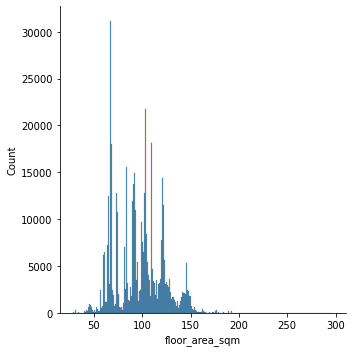

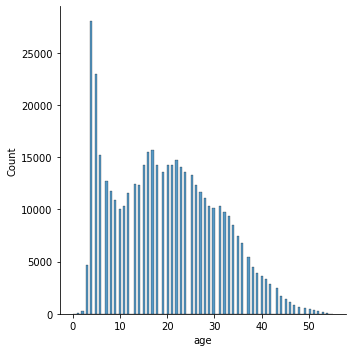

In [13]:
for col in list(X.select_dtypes(['number']).columns):
    sns.displot(X[col])

plt.show()


In [14]:
total = 0
for col in X.select_dtypes('object'):
    total += len(list(X[col].unique()))
    print(col, len(list(X[col].unique())))

total += len(X.select_dtypes('number').columns)
total


town 26
flat_type 7
storey_range 25
flat_model 11
sold_year 23


94

In [15]:
# Apply StandardScaler and Normalizer to numeric data (new)

ct = make_column_transformer(
    (Pipeline([
        ('scaler', StandardScaler()),
        ('normalize', Normalizer()),
    ]),
     make_column_selector(dtype_include=np.number)),  
    (OneHotEncoder(drop='first'),
     make_column_selector(dtype_include=object)))  

ct.fit(X)
preprocessed_df = ct.transform(X)


In [16]:

preprocessed_df.shape


(462515, 89)

In [17]:
# Select most influenctial Features using based on the f-value
# tuning value of k, features to select
'''
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, Y,test_size=0.33, random_state=42)
tunningResults = []
for i in range(40, X_train.shape[1]):
    selectbest = SelectKBest(
        score_func=f_regression, k=i)
    X_selected = selectbest.fit_transform(X_train, y_train)
    est = sm.OLS(y_train.values.ravel(),
                 sm.add_constant(X_selected.toarray())).fit()
    kSelectColumnFilter = []
    for i in range(len(selectbest.get_support())):
        if selectbest.get_support()[i]:
            kSelectColumnFilter.append(i)
    y_pred = est.predict(sm.add_constant(
        X_test[:, kSelectColumnFilter].toarray()))
    # print(est.summary())
    tunningResults.append((est.rsquared_adj, mean_squared_error(
        y_test, y_pred), r2_score(y_test, y_pred)))
'''

# rsquared_adj.index(max(rsquared_adj))

# sns.lineplot(rsquared_adj,range(1,preprocessed_df.shape[1]))
# result of this is 96


'\nX_train, X_test, y_train, y_test = train_test_split(preprocessed_df, Y,test_size=0.33, random_state=42)\ntunningResults = []\nfor i in range(40, X_train.shape[1]):\n    selectbest = SelectKBest(\n        score_func=f_regression, k=i)\n    X_selected = selectbest.fit_transform(X_train, y_train)\n    est = sm.OLS(y_train.values.ravel(),\n                 sm.add_constant(X_selected.toarray())).fit()\n    kSelectColumnFilter = []\n    for i in range(len(selectbest.get_support())):\n        if selectbest.get_support()[i]:\n            kSelectColumnFilter.append(i)\n    y_pred = est.predict(sm.add_constant(\n        X_test[:, kSelectColumnFilter].toarray()))\n    # print(est.summary())\n    tunningResults.append((est.rsquared_adj, mean_squared_error(\n        y_test, y_pred), r2_score(y_test, y_pred)))\n'

In [18]:


# selectbest = SelectKBest(
#     f_regression, k=98)
# X_selected = selectbest.fit_transform(preprocessed_df, Y)
est = sm.OLS(Y.values.ravel(), sm.add_constant(preprocessed_df.toarray())).fit()


In [19]:
# kSelectColumnFilter = []
# for i in range(len(selectbest.get_support())):
#     if selectbest.get_support()[i]:
#         kSelectColumnFilter.append(i)

# selectbest.get_support().shape


In [20]:
print(est.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 3.986e+04
Date:                Tue, 19 Apr 2022   Prob (F-statistic):               0.00
Time:                        23:07:11   Log-Likelihood:            -5.6738e+06
No. Observations:              462515   AIC:                         1.135e+07
Df Residuals:                  462425   BIC:                         1.135e+07
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.972e+04   1.11e+04      4.476      0.0

In [21]:
len(est.pvalues)


90

In [22]:
featureFilter = list(map(lambda x:x <0.05, est.pvalues))
print(len(featureFilter))
kSelectColumnFilter = []
for i in range(1,len(featureFilter)):
    if featureFilter[i]:
        kSelectColumnFilter.append(i-1)
kSelectColumnFilter


90


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88]

In [23]:
preprocessed_df[:, kSelectColumnFilter]


<462515x89 sparse matrix of type '<class 'numpy.float64'>'
	with 3093940 stored elements in Compressed Sparse Row format>

In [24]:
# retrain 
est = sm.OLS(Y.values.ravel(), sm.add_constant(
    preprocessed_df[:, kSelectColumnFilter].toarray())).fit()


In [25]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 3.986e+04
Date:                Tue, 19 Apr 2022   Prob (F-statistic):               0.00
Time:                        23:07:36   Log-Likelihood:            -5.6738e+06
No. Observations:              462515   AIC:                         1.135e+07
Df Residuals:                  462425   BIC:                         1.135e+07
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.972e+04   1.11e+04      4.476      0.0

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_df, Y, test_size=0.33, random_state=42)

y_pred = est.predict(sm.add_constant(X_test[:,kSelectColumnFilter].toarray()))

mean_squared_error(
    y_test, y_pred), r2_score(y_test, y_pred)


(2647674253.760332, 0.8849248889286893)

Looking at the residual plot of story vs resale_price, the relationship between these 2 variables are not linear. which make sense as the impact of floors on the price of the property at lower floors are much higher when compared to at higher floorts

Since the F-statistic value is very large and Prob (F-statistic) is less than 0.05, we have sufficient evidence that there is a good amount of linear relationship between the target variable and the feature variables

In [124]:
test_data = pd.read_csv('./test.csv')
X_test = cleanData(test_data)



In [125]:
total = 0
for col in X_test.select_dtypes('object'):
    total += len(list(X[col].unique()))
    print(col, len(list(X[col].unique())))

total += len(X_test.select_dtypes('number').columns)
total

town 26
flat_type 7
storey_range 25
flat_model 20
sold_year 23


103

In [126]:
preprocessed_X_test = ct.transform(X_test)
preprocessed_X_test=preprocessed_X_test[:, kSelectColumnFilter]



In [127]:
preprocessed_X_test.shape


(115629, 96)

In [128]:
y_pred = est.predict(sm.add_constant(preprocessed_X_test.toarray()))


In [129]:
y_pred.shape

(115629,)

In [130]:
submission = pd.DataFrame(
    y_pred, columns=['Resale_price'])

submission['Index'] = np.arange(1, len(submission)+1)

submission = submission[['Index', 'Resale_price']]


In [131]:
submission.to_csv('submission.csv', index=False)


In [132]:
submission

,Index,Resale_price
0,1,284233.784925
1,2,423337.144503
2,3,387159.874347
3,4,575493.599397
4,5,108534.321540
...,...,...
115624,115625,197897.853881
115625,115626,174853.630928
115626,115627,400772.724090
115627,115628,165776.749032
